In [1]:
from openai import OpenAI
import pandas as pd
import json
import duckdb
from pydantic import BaseModel, Field

In [4]:
model="gpt-4o-2024-08-06"

In [5]:
# define the path to the transactional data
TRANSACTION_DATA_FILE_PATH = 'Store_Sales_Price_Elasticity_Promotions_Data.parquet'

In [7]:
df=pd.read_parquet(TRANSACTION_DATA_FILE_PATH)
df

,Store_Number,SKU_Coded,Product_Class_Code,Sold_Date,Qty_Sold,Total_Sale_Value,On_Promo
0,1320,6172800,22875,2021-11-02,3,56.849998,0
1,2310,6172800,22875,2021-11-03,1,18.950001,0
2,3080,6172800,22875,2021-11-03,1,18.950001,0
3,2310,6172800,22875,2021-11-06,1,18.950001,0
4,4840,6172800,22875,2021-11-07,1,18.950001,0
...,...,...,...,...,...,...,...
697889,880,6205800,22875,2024-03-30,1,6.990000,0
697890,2970,6205850,24375,2024-03-29,1,69.989998,0
697891,3630,6205900,22850,2024-03-24,3,59.970001,0
697892,2970,6205900,22850,2024-03-27,1,19.990000,0


In [8]:
df.head()

,Store_Number,SKU_Coded,Product_Class_Code,Sold_Date,Qty_Sold,Total_Sale_Value,On_Promo
0,1320,6172800,22875,2021-11-02,3,56.849998,0
1,2310,6172800,22875,2021-11-03,1,18.950001,0
2,3080,6172800,22875,2021-11-03,1,18.950001,0
3,2310,6172800,22875,2021-11-06,1,18.950001,0
4,4840,6172800,22875,2021-11-07,1,18.950001,0


In [10]:
df.describe()

,Store_Number,SKU_Coded,Product_Class_Code,Qty_Sold,Total_Sale_Value,On_Promo
count,697894.000000,6.978940e+05,697894.000000,697894.000000,697894.000000,697894.000000
mean,2322.063537,6.188240e+06,23284.495747,1.484536,19.018131,0.006256
std,1174.914952,9.044149e+03,672.547472,2.111665,24.517405,0.078847
min,330.000000,6.172800e+06,22800.000000,1.000000,0.010000,0.000000
25%,1320.000000,6.179300e+06,22850.000000,1.000000,6.990000,0.000000
50%,2310.000000,6.188400e+06,22925.000000,1.000000,10.950000,0.000000
75%,3190.000000,6.195950e+06,24375.000000,1.000000,21.990000,0.000000
max,4840.000000,6.205900e+06,24425.000000,239.000000,2094.090088,1.000000


In [6]:
# prompt template for step 2 of tool 1
SQL_GENERATION_PROMPT = """
Generate an SQL query based on a prompt. Do not reply with anything besides the SQL query.
The prompt is: {prompt}

The available columns are: {columns}
The table name is: {table_name}
"""

In [11]:
# code for step 2 of tool 1
def generate_sql_query(prompt: str, columns: list, table_name: str) -> str:
    """Generate an SQL query based on a prompt"""
    formatted_prompt = SQL_GENERATION_PROMPT.format(prompt=prompt, 
                                                    columns=columns, 
                                                    table_name=table_name)

    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": formatted_prompt}],
    )
    
    return response.choices[0].message.content

In [12]:
# code for tool 1
def lookup_sales_data(prompt: str) -> str:
    """Implementation of sales data lookup from parquet file using SQL"""
    try:
        # define the table name
        table_name = "sales"
        
        # step 1: read the parquet file into a DuckDB table
        df = pd.read_parquet(TRANSACTION_DATA_FILE_PATH)
        duckdb.sql(f"CREATE TABLE IF NOT EXISTS {table_name} AS SELECT * FROM df")

        # step 2: generate the SQL code
        sql_query = generate_sql_query(prompt, df.columns, table_name)
        print(sql_query)
        # clean the response to make sure it only includes the SQL code
        sql_query = sql_query.strip()
        print(sql_query)
        sql_query = sql_query.replace("```sql", "").replace("```", "")
        print(sql_query)
        
        # step 3: execute the SQL query
        result = duckdb.sql(sql_query).df()
        
        return result.to_string()
    except Exception as e:
        return f"Error accessing data: {str(e)}"

In [13]:
example_data = lookup_sales_data("Show me all the sales for store 1320 on November 1st, 2021")
print(example_data)

```sql
SELECT *
FROM sales
WHERE Store_Number = 1320 AND Sold_Date = '2021-11-01';
```
```sql
SELECT *
FROM sales
WHERE Store_Number = 1320 AND Sold_Date = '2021-11-01';
```

SELECT *
FROM sales
WHERE Store_Number = 1320 AND Sold_Date = '2021-11-01';

    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo
0           1320    6173050               22875 2021-11-01         1          4.990000         0
1           1320    6174250               22875 2021-11-01         1          0.890000         0
2           1320    6176200               22975 2021-11-01         2         99.980003         0
3           1320    6176800               22800 2021-11-01         1         14.970000         0
4           1320    6177250               22975 2021-11-01         1          6.890000         0
5           1320    6177300               22800 2021-11-01         1          9.990000         0
6           1320    6177350               22800 2021-11-01         2 

In [14]:
# Construct prompt based on analysis type and data subset
DATA_ANALYSIS_PROMPT = """
Analyze the following data: {data}
Your job is to answer the following question: {prompt}
"""

In [15]:
# code for tool 2
def analyze_sales_data(prompt: str, data: str) -> str:
    """Implementation of AI-powered sales data analysis"""
    formatted_prompt = DATA_ANALYSIS_PROMPT.format(data=data, prompt=prompt)

    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": formatted_prompt}],
    )
    
    analysis = response.choices[0].message.content
    return analysis if analysis else "No analysis could be generated"

In [16]:
print(analyze_sales_data(prompt="what trends do you see in this data", data=example_data))

Based on the data provided, here are some trends and observations:

1. **Promotion Impact:**
   - Almost all sales transactions are not on promotion (`On_Promo = 0`) except one transaction (`On_Promo = 1`). It appears that most products sold on the given date were at regular prices.

2. **Quantity Sold and Total Sale Value:**
   - The quantities sold per transaction are generally low, with most transactions involving 1 or 2 units sold.
   - There are a few transactions with higher quantities (e.g., 3 or 5 units), and these tend to be associated with higher total sale values, although not proportionally higher per unit sale price.

3. **Product Class Distribution:**
   - Product sales span several product class codes, with some more frequently appearing, such as Product Class Code 22800 and 24400.
   - There are limited transactions for each product class code, making it difficult to discern strong patterns of preference for certain product classes.

4. **SKU Analysis:**
   - Each trans

In [17]:
# prompt template for step 1 of tool 3
CHART_CONFIGURATION_PROMPT = """
Generate a chart configuration based on this data: {data}
The goal is to show: {visualization_goal}
"""

In [18]:
# class defining the response format of step 1 of tool 3
class VisualizationConfig(BaseModel):
    chart_type: str = Field(..., description="Type of chart to generate")
    x_axis: str = Field(..., description="Name of the x-axis column")
    y_axis: str = Field(..., description="Name of the y-axis column")
    title: str = Field(..., description="Title of the chart")

In [19]:
# code for step 1 of tool 3
def extract_chart_config(data: str, visualization_goal: str) -> dict:
    """Generate chart visualization configuration
    
    Args:
        data: String containing the data to visualize
        visualization_goal: Description of what the visualization should show
        
    Returns:
        Dictionary containing line chart configuration
    """
    formatted_prompt = CHART_CONFIGURATION_PROMPT.format(data=data, visualization_goal=visualization_goal)
    
    response = client.beta.chat.completions.parse(
        model=model,
        messages=[{"role": "user", "content": formatted_prompt}],
        response_format=VisualizationConfig,
    )
    
    try:
        # Extract axis and title info from response
        content = response.choices[0].message.content
        
        # Return structured chart config
        return {
            "chart_type": content.chart_type,
            "x_axis": content.x_axis,
            "y_axis": content.y_axis,
            "title": content.title,
            "data": data
        }
    except Exception:
        return {
            "chart_type": "line", 
            "x_axis": "date",
            "y_axis": "value",
            "title": visualization_goal,
            "data": data
        }

In [20]:
# prompt template for step 2 of tool 3
CREATE_CHART_PROMPT = """
Write python code to create a chart based on the following configuration.
Only return the code, no other text.
config: {config}
"""

In [21]:
# code for step 2 of tool 3
def create_chart(config: dict) -> str:
    """Create a chart based on the configuration"""
    formatted_prompt = CREATE_CHART_PROMPT.format(config=config)
    
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": formatted_prompt}],
    )
    
    code = response.choices[0].message.content
    code = code.replace("```python", "").replace("```", "")
    code = code.strip()
    
    return code

In [22]:
# code for tool 3
def generate_visualization(data: str, visualization_goal: str) -> str:
    """Generate a visualization based on the data and goal"""
    config = extract_chart_config(data, visualization_goal)
    code = create_chart(config)
    return code

In [23]:
code = generate_visualization(example_data,"A bar chart of sales by product SKU. Put the product SKU on the x-axis and the sales on the y-axis.")
print(code)

import pandas as pd
import matplotlib.pyplot as plt
from io import StringIO

data = '''
    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo
0           1320    6173050               22875 2021-11-01         1          4.990000         0
1           1320    6174250               22875 2021-11-01         1          0.890000         0
2           1320    6176200               22975 2021-11-01         2         99.980003         0
3           1320    6176800               22800 2021-11-01         1         14.970000         0
4           1320    6177250               22975 2021-11-01         1          6.890000         0
5           1320    6177300               22800 2021-11-01         1          9.990000         0
6           1320    6177350               22800 2021-11-01         2         16.980000         0
7           1320    6177700               22875 2021-11-01         1          3.190000         0
8           1320    6178000            

<string>:39: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead


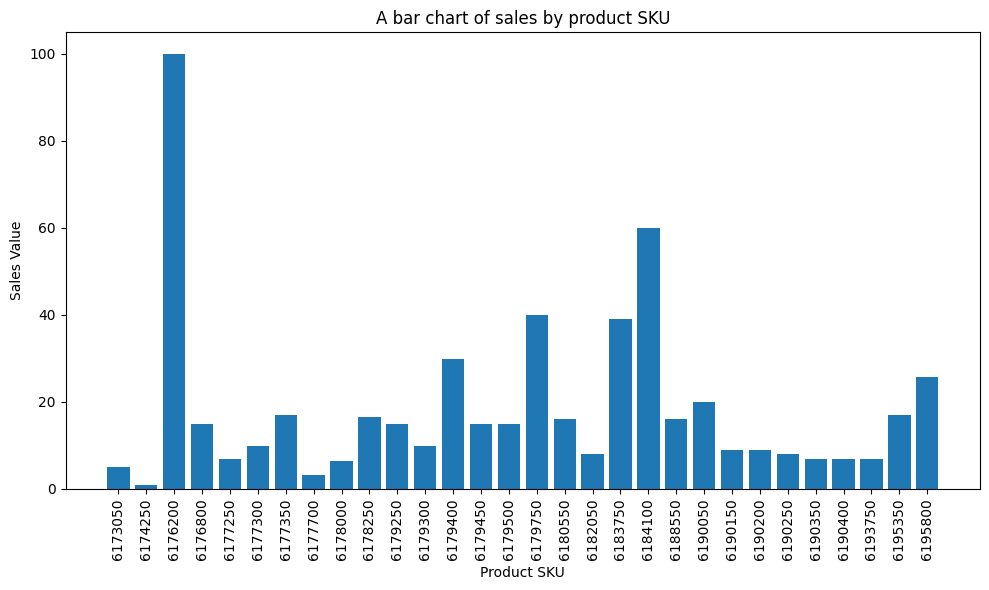

In [24]:
exec(code)

In [25]:
# Define tools/functions that can be called by the model
tools = [
    {
        "type": "function",
        "function": {
            "name": "lookup_sales_data",
            "description": "Look up data from Store Sales Price Elasticity Promotions dataset",
            "parameters": {
                "type": "object",
                "properties": {
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "analyze_sales_data", 
            "description": "Analyze sales data to extract insights",
            "parameters": {
                "type": "object",
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "prompt": {"type": "string", "description": "The unchanged prompt that the user provided."}
                },
                "required": ["data", "prompt"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "generate_visualization",
            "description": "Generate Python code to create data visualizations",
            "parameters": {
                "type": "object", 
                "properties": {
                    "data": {"type": "string", "description": "The lookup_sales_data tool's output."},
                    "visualization_goal": {"type": "string", "description": "The goal of the visualization."}
                },
                "required": ["data", "visualization_goal"]
            }
        }
    }
]

# Dictionary mapping function names to their implementations
tool_implementations = {
    "lookup_sales_data": lookup_sales_data,
    "analyze_sales_data": analyze_sales_data, 
    "generate_visualization": generate_visualization
}

In [26]:
# code for executing the tools returned in the model's response
def handle_tool_calls(tool_calls, messages):
    
    for tool_call in tool_calls:   
        function = tool_implementations[tool_call.function.name]
        function_args = json.loads(tool_call.function.arguments)
        result = function(**function_args)
        messages.append({"role": "tool", "content": result, "tool_call_id": tool_call.id})
        
    return messages

In [27]:
SYSTEM_PROMPT = """
You are a helpful assistant that can answer questions about the Store Sales Price Elasticity Promotions dataset.
"""

In [28]:
def run_agent(messages):
    print("Running agent with messages:", messages)

    if isinstance(messages, str):
        messages = [{"role": "user", "content": messages}]
        
    # Check and add system prompt if needed
    if not any(
            isinstance(message, dict) and message.get("role") == "system" for message in messages
        ):
            system_prompt = {"role": "system", "content": SYSTEM_PROMPT}
            messages.append(system_prompt)

    while True:
        print("Making router call to OpenAI")
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            tools=tools,
        )
        messages.append(response.choices[0].message)
        tool_calls = response.choices[0].message.tool_calls
        print("Received response with tool calls:", bool(tool_calls))

        # if the model decides to call function(s), call handle_tool_calls
        if tool_calls:
            print("Processing tool calls")
            messages = handle_tool_calls(tool_calls, messages)
        else:
            print("No tool calls, returning final response")
            return response.choices[0].message.content

In [29]:
result = run_agent('Show me the code for graph of sales by store in Nov 2021, and tell me what trends you see.')

Running agent with messages: Show me the code for graph of sales by store in Nov 2021, and tell me what trends you see.
Making router call to OpenAI
Received response with tool calls: True
Processing tool calls
```sql
SELECT Store_Number, SUM(Total_Sale_Value) AS Total_Sales
FROM sales
WHERE Sold_Date BETWEEN '2021-11-01' AND '2021-11-30'
GROUP BY Store_Number;
```
```sql
SELECT Store_Number, SUM(Total_Sale_Value) AS Total_Sales
FROM sales
WHERE Sold_Date BETWEEN '2021-11-01' AND '2021-11-30'
GROUP BY Store_Number;
```

SELECT Store_Number, SUM(Total_Sale_Value) AS Total_Sales
FROM sales
WHERE Sold_Date BETWEEN '2021-11-01' AND '2021-11-30'
GROUP BY Store_Number;

Making router call to OpenAI
Received response with tool calls: True
Processing tool calls
Making router call to OpenAI
Received response with tool calls: False
No tool calls, returning final response


In [30]:
result

"Here's the Python code to create a graph of sales by store in November 2021:\n\n```python\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\ndata = {\n    'Store_Number': [550, 4180, 1650, 990, 2090, 4840, 2640, 3080, 4070, 1100, 3190, 3410, 4730, 1540, 1320, 660, 770, 2530, 4400, 2970, 1760, 330, 1210, 3740, 2750, 1980, 3300, 880, 2420, 1870, 3630, 2200, 2310],\n    'Total_Sales': [9554.049975, 10213.81992, 23186.909958, 15101.459945, 11617.179888, 19127.169971, 10891.639931, 18044.450005, 9161.409921, 19298.679917, 11934.999961, 15982.159946, 10571.779962, 21207.689942, 19553.789981, 13041.239901, 9181.769959, 11139.740003, 4390.689987, 31000.569969, 14598.209948, 12569.599911, 21021.669984, 10719.049952, 16310.409961, 9084.959929, 23730.719905, 17753.769956, 15234.709888, 17091.849894, 14202.299958, 16854.439921, 16611.539945]\n}\n\ndf = pd.DataFrame(data)\n\nplt.figure(figsize=(10, 6))\nplt.plot(df['Store_Number'], df['Total_Sales'], marker='o')\nplt.title('Sales by Store in